## Шаг 0
## Подготовка:
####   Импорт библиотек
####   Загрузка таблиц

In [500]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [501]:
def min_max(param, categorial_features):
    if not(param in categorial_features):
        max1 = max(max(df_train[param]), max(df_test[param]))
        min1 = min(min(df_train[param]), min(df_test[param]))
        df_train[param] = df_train[param].apply(lambda x: (x-min1)/(max1-min1))
        df_test[param] = df_test[param].apply(lambda x: (x-min1)/(max1-min1))

In [502]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [503]:
fill_features = [
    'ExterQual',
    'HeatingQC',
    'FireplaceQu',
    'KitchenQual',
    'BsmtQual',
    'GarageQual',
    'BsmtCond',
    'ExterCond',
    'GarageFinish'
]

In [504]:
df_train['MasVnrArea'].fillna(0, inplace=True)
df_train['TotalBsmtSF'].fillna(0, inplace=True)
df_train['GarageCars'].fillna(0, inplace=True)
df_train['SaleType'].fillna('WD', inplace=True)
df_test['MasVnrArea'].fillna(0, inplace=True)
df_test['TotalBsmtSF'].fillna(0, inplace=True)
df_test['GarageCars'].fillna(0, inplace=True)
df_test['SaleType'].fillna('WD', inplace=True)
for param in fill_features:
    df_train[param].fillna('Not', inplace=True)
    df_test[param].fillna('Not', inplace=True)

In [505]:
exter_qual_dict = {'Not': 0, 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
df_train['ExterQual'] = df_train['ExterQual'].apply(lambda x: exter_qual_dict[x])
df_train['FireplaceQu'] = df_train['FireplaceQu'].apply(lambda x: exter_qual_dict[x])
df_train['KitchenQual'] = df_train['KitchenQual'].apply(lambda x: exter_qual_dict[x])
df_train['BsmtQual'] = df_train['BsmtQual'].apply(lambda x: exter_qual_dict[x])
df_test['ExterQual'] = df_test['ExterQual'].apply(lambda x: exter_qual_dict[x])
df_test['FireplaceQu'] = df_test['FireplaceQu'].apply(lambda x: exter_qual_dict[x])
df_test['KitchenQual'] = df_test['KitchenQual'].apply(lambda x: exter_qual_dict[x])
df_test['BsmtQual'] = df_test['BsmtQual'].apply(lambda x: exter_qual_dict[x])


heating_dict = {'Po': 1, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
df_train['HeatingQC'] = df_train['HeatingQC'].apply(lambda x: heating_dict[x])
df_test['HeatingQC'] = df_test['HeatingQC'].apply(lambda x: heating_dict[x])


exter_cond_dict = {'Not': 1, 'Po': 1, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 3}
df_train['ExterCond'] = df_train['ExterCond'].apply(lambda x: exter_cond_dict[x])
df_test['ExterCond'] = df_test['ExterCond'].apply(lambda x: exter_cond_dict[x])

garage_dict = {'Not': 0, 'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 3}
df_train['GarageQual'] = df_train['GarageQual'].apply(lambda x: garage_dict[x])
df_train['BsmtCond'] = df_train['BsmtCond'].apply(lambda x: garage_dict[x])
df_test['GarageQual'] = df_test['GarageQual'].apply(lambda x: garage_dict[x])
df_test['BsmtCond'] = df_test['BsmtCond'].apply(lambda x: garage_dict[x])

In [506]:
# s = 'LandContour'
# df_train = df_train[(df_train[s] != 'Bnk') | (df_train['SalePrice'] < 300000)]

# s = 'TotalBsmtSF'
# df_train = df_train[(df_train[s] < 5000) & (df_train['SalePrice'] < 470000)]

# s = 'GrLivArea'
# df_train = df_train[df_train[s] < 4000]

####

# s = 'GarageArea'
# df_train = df_train[(df_train[s] < 1200) | (df_train['SalePrice'] > 300000)]

# s = 'TotalBsmtSF'
# df_train = df_train[df_train[s] < 2500]

# s = 'TotRmsAbvGrd'
# df_train = df_train[(df_train[s] < 14)]
# df_train = df_train[(df_train[s] != 5) | (df_train['SalePrice'] < 350000)]

# s = 'MSZoning'
# df_train = df_train[(df_train[s] != 3) | (df_train['SalePrice'] < 250000)]
# df_train = df_train[(df_train[s] != 5) | (df_train['SalePrice'] < 320000)]

# s = 'CentralAir'
# df_train = df_train[(df_train[s] != 0) | (df_train['SalePrice'] < 200000)]

# s = 'GarageCars'
# df_train = df_train[(df_train[s] != 0) | (df_train['SalePrice'] < 190000)]
# df_train = df_train[(df_train[s] != 2) | (df_train['SalePrice'] < 350000)]

df_train['SalePrice'] = df_train['SalePrice'].apply(np.log1p)

In [507]:
df_train['Fireplaces'] = df_train['Fireplaces'].apply(lambda x: 2 if x >= 2 else x)
df_test['Fireplaces'] = df_test['Fireplaces'].apply(lambda x: 2 if x >= 2 else x)

In [508]:
df_train['TotRmsAbvGrd'] = df_train['TotRmsAbvGrd'].apply(lambda x: 9 if x >= 9 else x)
df_train['TotRmsAbvGrd'] = df_train['TotRmsAbvGrd'].apply(lambda x: 4 if x <= 4 else x)
df_test['TotRmsAbvGrd'] = df_test['TotRmsAbvGrd'].apply(lambda x: 9 if x >= 9 else x)
df_test['TotRmsAbvGrd'] = df_test['TotRmsAbvGrd'].apply(lambda x: 4 if x <= 4 else x)

In [509]:
df_train['GarageCars'] = df_train['GarageCars'].apply(lambda x: 3 if x >= 3 else x)
df_test['GarageCars'] = df_test['GarageCars'].apply(lambda x: 3 if x >= 3 else x)

In [510]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [511]:
df_train['TotalYear'] = df_train['YrSold'] - df_train['YearBuilt']
df_test['TotalYear'] = df_test['YrSold'] - df_test['YearBuilt']

In [512]:
neighbor_dict = {
    'Blmngtn': 'Blmngtn',
    'Blueste': 'Mitchel',
    'BrDale': 'IDOTRR',
    'BrkSide': 'OldTown',
    'ClearCr': 'CollgCr',
    'CollgCr': 'CollgCr',
    'Crawfor': 'CollgCr',
    'Edwards': 'Edwards',
    'Gilbert': 'Blmngtn',
    'IDOTRR': 'IDOTRR',
    'MeadowV': 'IDOTRR',
    'Mitchel': 'Mitchel',
    'NAmes': 'NAmes',
    'NPkVill': 'Mitchel',
    'NWAmes': 'NWAmes',
    'NoRidge': 'NoRidge',
    'NridgHt': 'NoRidge',
    'OldTown': 'OldTown',
    'SWISU': 'Mitchel',
    'Sawyer': 'Sawyer',
    'SawyerW': 'NWAmes',
    'Somerst': 'Timber',
    'StoneBr': 'StoneBr',
    'Timber': 'Timber',
    'Veenker': 'Timber'
}
df_train['Neighborhood'] = df_train['Neighborhood'].apply(lambda x: neighbor_dict[x])
df_test['Neighborhood'] = df_test['Neighborhood'].apply(lambda x: neighbor_dict[x])

In [513]:
saletype_dict = {
    'COD': 'COD',
    'CWD': 'CWD',
    'Con': 'New',
    'ConLD': 'COD',
    'ConLI': 'COD',
    'ConLw': 'COD', 
    'New': 'New',
    'Oth': 'COD',
    'WD': 'CWD'
}
df_train['SaleType'] = df_train['SaleType'].apply(lambda x: saletype_dict[x])
df_test['SaleType'] = df_test['SaleType'].apply(lambda x: saletype_dict[x])

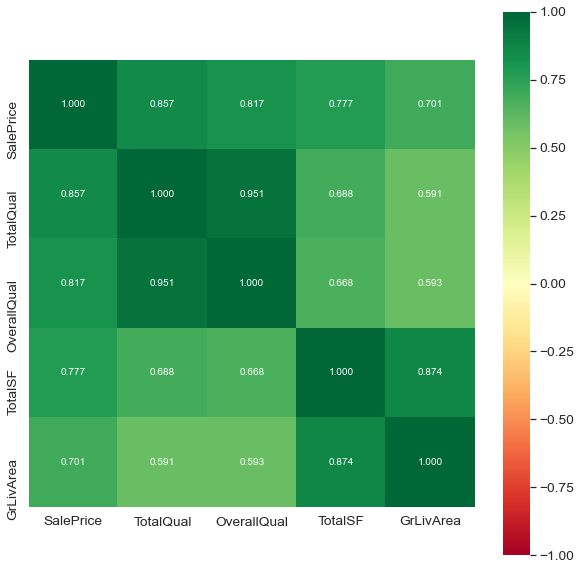

In [514]:
quals = [
    'SalePrice',
    'OverallQual',
    'ExterQual',
    'HeatingQC',
    'FireplaceQu',
    'KitchenQual',
    'BsmtQual',
    'GarageQual',
    'BsmtCond',
    'ExterCond',
    'OverallCond'
]
quals_dict = {
    'SalePrice': 1,
    'OverallQual': 2,
    'ExterQual': 2,
    'HeatingQC': 0.5,
    'FireplaceQu': 1,
    'KitchenQual': 2,
    'BsmtQual': 1,
    'GarageQual': 1,
    'BsmtCond': 0.2,
    'ExterCond': 1,
    'OverallCond': 1
}
df_train['TotalQual'] = 0
df_test['TotalQual'] = 0
cm = np.corrcoef(df_train[quals].values.T)[0]
for i in range(1, len(quals)):
    df_train['TotalQual'] += df_train[quals[i]]*quals_dict[quals[i]]*int(abs(cm[i]*10))
    df_test['TotalQual'] += df_test[quals[i]]*quals_dict[quals[i]]*int(abs(cm[i]*10))

k = 5
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.3f', annot_kws={'size': 10}, cmap='RdYlGn',
                center=0, vmax=1, vmin=-1,
                yticklabels=cols.values, xticklabels=cols.values)

In [515]:
# df_train['TotalFlrSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']
# df_test['TotalFlrSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [516]:
df_train['TotalQualWithLog'] = df_train['TotalQual'].apply(np.log1p)
df_test['TotalQualWithLog'] = df_test['TotalQual'].apply(np.log1p)

<AxesSubplot:ylabel='Density'>

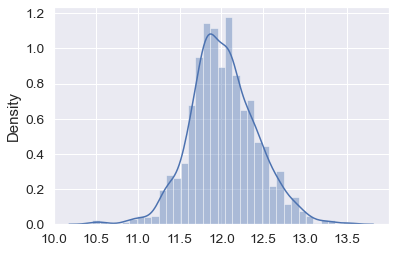

In [517]:
sns.distplot(x=df_train['SalePrice'])

In [518]:
# df_train.drop(columns = quals[1:], inplace = True)
# df_test.drop(columns = quals[1:], inplace = True)

In [519]:
# equip = ['Fireplaces', 'CentralAir', 'GarageCars', 'PavedDrive', 'PoolArea',
#          'Electrical']
# equip_dict = {'Fireplaces': 0.6, 'CentralAir': 1, 'GarageCars': 1, 'PavedDrive': 1, 'Heating': 1,
#               'Foundation': 0.1, 'PoolArea': 10, 'Electrical': 1}
# df_train['Equipment'] = 0
# df_test['Equipment'] = 0
# cm = np.corrcoef(df_train[equip].values.T)[0]
# for i in range(0, len(equip)):
#     df_train['Equipment'] += df_train[equip[i]]*equip_dict[equip[i]]*int(abs(cm[i]*100))
#     df_test['Equipment'] += df_test[equip[i]]*equip_dict[equip[i]]*int(abs(cm[i]*100))

# k = 20
# corrmat = df_train.corr()
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(df_train[cols].values.T)
# sns.set(font_scale=1.25)
# plt.figure(figsize = (22, 22))
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
#                 fmt='.3f', annot_kws={'size': 15}, cmap='RdYlGn',
#                 center=0, vmax=1, vmin=-1,
#                 yticklabels=cols.values, xticklabels=cols.values)

In [520]:
# df_train.drop(columns = equip, inplace = True)
# df_test.drop(columns = equip, inplace = True)

In [521]:
numerical_features = [i for i in df_train.columns if df_train[i].dtypes != 'O']
categorial_features = [i for i in df_train.columns if df_train[i].dtypes == 'O']
train_features_with_na = [i for i in df_train if df_train[i].isna().sum()]

for i in numerical_features:
    if i != 'SalePrice':
        df_train[i] = df_train[i].astype('double')
        df_test[i] = df_test[i].astype('double')
    

In [522]:
# for col in categorial_features:
#     encoder = LabelEncoder()
#     df_train[col] = encoder.fit_transform(df_train[col])

In [523]:
# df_train = df_train[df_train['TotalSF'] <= 5000]
df_train = df_train[df_train['TotalQualWithLog'] >= 4.6]
df_train = df_train[df_train['TotalYear'] <= 122]
# df_train = df_train[df_train['SalePrice'] >= 11]
# df_train = df_train[df_train['SalePrice'] <= 13]
df_train = df_train[df_train['GrLivArea'] <= 3500]
df_train = df_train[df_train['LotArea'] <= 25000]

In [524]:
df_train = df_train.reset_index(drop = True)

In [525]:
features = [ # SalePrice выбросы обработаны
    'TotalQualWithLog', # выбросы обработаны
    'TotalSF', # выбросы обработаны 
     'Fireplaces',
    'GrLivArea', # выбросы обработаны
    'GarageCars',
    'Neighborhood', 
    'LotShape',
     'LandContour',
    'SaleType', # выбросов нет
    'TotalYear', # выбросы обработаны
    'TotRmsAbvGrd', # пошаманил, но не уверен, что стало лучше =)
     'MSZoning',
     'GarageFinish',
     'GarageType',
    'LotArea' # выбросы обработаны
]

# features = [
#     'TotalQualWithLog', # +
#     'GarageCars', 
#     'GrLivArea', # +
#     'TotalSF', # +
#     'Neighborhood',
#     'LotShape',
#     'TotRmsAbvGrd',
#     'LandContour',
#     'SaleType', # +
#     'TotalYear', # +
#     'LotArea'
# ]

y = df_train['SalePrice']
X = pd.get_dummies(df_train[features]) 
test_X = pd.get_dummies(df_test[features])

for i in features:
    min_max(i, categorial_features)

# train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.3)


lin_model = LinearRegression()
las_model = Lasso(alpha=60)
cat_model = CatBoostRegressor(iterations=9999)
xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
lgb_model = LGBMRegressor()

lgb_model.fit(X, y)
pred_y1 = lgb_model.predict(test_X)
lin_model.fit(X, y)
pred_y2 = lin_model.predict(test_X)
cat_model.fit(X, y)
pred_y5 = cat_model.predict(test_X)
xgb_model.fit(X, y)
pred_y6 = xgb_model.predict(test_X)

# lgb_model.fit(train_x, train_y)
# pred_y1 = lgb_model.predict(val_x)
# las_model.fit(train_x, train_y)
# pred_y2 = las_model.predict(val_x)
# cat_model.fit(train_x, train_y)
# pred_y5 = cat_model.predict(val_x)
# xgb_model.fit(train_x, train_y)
# pred_y6 = xgb_model.predict(val_x)

# pred_y1 = np.expm1(pred_y1)
# pred_y2 = np.expm1(pred_y2)
# pred_y5 = np.expm1(pred_y5)
# pred_y6 = np.expm1(pred_y6)

# val_y = np.expm1(val_y)
pred_y = (pred_y1 + pred_y2 + pred_y5 + pred_y6) / 4
# pred_y = np.expm1((pred_y1 + pred_y5 + pred_y6) / 3)
# print(f'LGB: {np.sqrt(mean_squared_error(val_y, pred_y1, squared=False))}')
# print(f'Lasso: {np.sqrt(mean_squared_error(val_y, pred_y2, squared=False))}')
# print(f'Cat: {np.sqrt(mean_squared_error(val_y, pred_y5, squared=False))}')
# print(f'XGB: {np.sqrt(mean_squared_error(val_y, pred_y6, squared=False))}')
# print(f'Ansamb: {np.sqrt(mean_squared_error(val_y, pred_y, squared=False))}')

Learning rate set to 0.00665
0:	learn: 0.3843009	total: 2.63ms	remaining: 26.3s
1:	learn: 0.3825491	total: 4.41ms	remaining: 22s
2:	learn: 0.3808377	total: 6.27ms	remaining: 20.9s
3:	learn: 0.3790369	total: 10.5ms	remaining: 26.3s
4:	learn: 0.3772297	total: 12.2ms	remaining: 24.4s
5:	learn: 0.3755623	total: 13.9ms	remaining: 23.1s
6:	learn: 0.3738973	total: 15.4ms	remaining: 22s
7:	learn: 0.3722885	total: 17ms	remaining: 21.3s
8:	learn: 0.3705216	total: 18.9ms	remaining: 20.9s
9:	learn: 0.3688441	total: 20.7ms	remaining: 20.6s
10:	learn: 0.3672184	total: 24.7ms	remaining: 22.4s
11:	learn: 0.3655237	total: 26.2ms	remaining: 21.8s
12:	learn: 0.3639336	total: 27.8ms	remaining: 21.4s
13:	learn: 0.3622313	total: 29.4ms	remaining: 21s
14:	learn: 0.3605587	total: 31ms	remaining: 20.6s
15:	learn: 0.3589382	total: 32.6ms	remaining: 20.3s
16:	learn: 0.3573719	total: 34.1ms	remaining: 20s
17:	learn: 0.3557240	total: 38.3ms	remaining: 21.2s
18:	learn: 0.3541386	total: 40.1ms	remaining: 21.1s
19:	l

192:	learn: 0.1915884	total: 490ms	remaining: 24.9s
193:	learn: 0.1910703	total: 492ms	remaining: 24.9s
194:	learn: 0.1906097	total: 494ms	remaining: 24.8s
195:	learn: 0.1901019	total: 495ms	remaining: 24.8s
196:	learn: 0.1896243	total: 497ms	remaining: 24.7s
197:	learn: 0.1891519	total: 498ms	remaining: 24.7s
198:	learn: 0.1886876	total: 500ms	remaining: 24.6s
199:	learn: 0.1882087	total: 501ms	remaining: 24.6s
200:	learn: 0.1877493	total: 503ms	remaining: 24.5s
201:	learn: 0.1873033	total: 505ms	remaining: 24.5s
202:	learn: 0.1868530	total: 506ms	remaining: 24.4s
203:	learn: 0.1863881	total: 508ms	remaining: 24.4s
204:	learn: 0.1859714	total: 509ms	remaining: 24.3s
205:	learn: 0.1855498	total: 511ms	remaining: 24.3s
206:	learn: 0.1851102	total: 512ms	remaining: 24.2s
207:	learn: 0.1846652	total: 514ms	remaining: 24.2s
208:	learn: 0.1842295	total: 516ms	remaining: 24.2s
209:	learn: 0.1838596	total: 518ms	remaining: 24.2s
210:	learn: 0.1834327	total: 520ms	remaining: 24.1s
211:	learn: 

382:	learn: 0.1409228	total: 809ms	remaining: 20.3s
383:	learn: 0.1407869	total: 811ms	remaining: 20.3s
384:	learn: 0.1406427	total: 812ms	remaining: 20.3s
385:	learn: 0.1405238	total: 814ms	remaining: 20.3s
386:	learn: 0.1403957	total: 816ms	remaining: 20.3s
387:	learn: 0.1402761	total: 818ms	remaining: 20.3s
388:	learn: 0.1401490	total: 819ms	remaining: 20.2s
389:	learn: 0.1400222	total: 821ms	remaining: 20.2s
390:	learn: 0.1398932	total: 822ms	remaining: 20.2s
391:	learn: 0.1397579	total: 824ms	remaining: 20.2s
392:	learn: 0.1396494	total: 826ms	remaining: 20.2s
393:	learn: 0.1394994	total: 827ms	remaining: 20.2s
394:	learn: 0.1393642	total: 829ms	remaining: 20.2s
395:	learn: 0.1392240	total: 833ms	remaining: 20.2s
396:	learn: 0.1390969	total: 834ms	remaining: 20.2s
397:	learn: 0.1389974	total: 836ms	remaining: 20.2s
398:	learn: 0.1388722	total: 838ms	remaining: 20.2s
399:	learn: 0.1387488	total: 839ms	remaining: 20.1s
400:	learn: 0.1386277	total: 841ms	remaining: 20.1s
401:	learn: 

606:	learn: 0.1240447	total: 1.28s	remaining: 19.9s
607:	learn: 0.1239955	total: 1.28s	remaining: 19.9s
608:	learn: 0.1239498	total: 1.29s	remaining: 19.8s
609:	learn: 0.1239008	total: 1.29s	remaining: 19.8s
610:	learn: 0.1238548	total: 1.29s	remaining: 19.8s
611:	learn: 0.1238178	total: 1.29s	remaining: 19.8s
612:	learn: 0.1237707	total: 1.29s	remaining: 19.8s
613:	learn: 0.1237352	total: 1.29s	remaining: 19.8s
614:	learn: 0.1236955	total: 1.3s	remaining: 19.8s
615:	learn: 0.1236624	total: 1.3s	remaining: 19.8s
616:	learn: 0.1236241	total: 1.3s	remaining: 19.8s
617:	learn: 0.1235830	total: 1.3s	remaining: 19.8s
618:	learn: 0.1235416	total: 1.3s	remaining: 19.8s
619:	learn: 0.1235008	total: 1.3s	remaining: 19.8s
620:	learn: 0.1234563	total: 1.31s	remaining: 19.7s
621:	learn: 0.1234152	total: 1.31s	remaining: 19.7s
622:	learn: 0.1233720	total: 1.31s	remaining: 19.7s
623:	learn: 0.1233269	total: 1.31s	remaining: 19.7s
624:	learn: 0.1232886	total: 1.31s	remaining: 19.7s
625:	learn: 0.1232

777:	learn: 0.1183649	total: 1.6s	remaining: 19s
778:	learn: 0.1183301	total: 1.6s	remaining: 19s
779:	learn: 0.1183101	total: 1.6s	remaining: 19s
780:	learn: 0.1182771	total: 1.6s	remaining: 18.9s
781:	learn: 0.1182456	total: 1.61s	remaining: 18.9s
782:	learn: 0.1182200	total: 1.61s	remaining: 18.9s
783:	learn: 0.1181981	total: 1.61s	remaining: 18.9s
784:	learn: 0.1181632	total: 1.61s	remaining: 18.9s
785:	learn: 0.1181359	total: 1.61s	remaining: 18.9s
786:	learn: 0.1181068	total: 1.61s	remaining: 18.9s
787:	learn: 0.1180699	total: 1.62s	remaining: 18.9s
788:	learn: 0.1180367	total: 1.62s	remaining: 18.9s
789:	learn: 0.1180154	total: 1.62s	remaining: 18.9s
790:	learn: 0.1179880	total: 1.62s	remaining: 18.9s
791:	learn: 0.1179665	total: 1.62s	remaining: 18.9s
792:	learn: 0.1179384	total: 1.62s	remaining: 18.9s
793:	learn: 0.1179153	total: 1.63s	remaining: 18.9s
794:	learn: 0.1178787	total: 1.63s	remaining: 18.8s
795:	learn: 0.1178587	total: 1.63s	remaining: 18.8s
796:	learn: 0.1178407	

1014:	learn: 0.1129817	total: 2.08s	remaining: 18.4s
1015:	learn: 0.1129560	total: 2.08s	remaining: 18.4s
1016:	learn: 0.1129384	total: 2.08s	remaining: 18.4s
1017:	learn: 0.1129125	total: 2.08s	remaining: 18.4s
1018:	learn: 0.1128997	total: 2.08s	remaining: 18.4s
1019:	learn: 0.1128801	total: 2.08s	remaining: 18.4s
1020:	learn: 0.1128686	total: 2.09s	remaining: 18.4s
1021:	learn: 0.1128338	total: 2.09s	remaining: 18.3s
1022:	learn: 0.1128077	total: 2.09s	remaining: 18.3s
1023:	learn: 0.1127831	total: 2.09s	remaining: 18.3s
1024:	learn: 0.1127587	total: 2.09s	remaining: 18.3s
1025:	learn: 0.1127442	total: 2.09s	remaining: 18.3s
1026:	learn: 0.1127291	total: 2.1s	remaining: 18.3s
1027:	learn: 0.1127040	total: 2.1s	remaining: 18.3s
1028:	learn: 0.1126846	total: 2.1s	remaining: 18.3s
1029:	learn: 0.1126598	total: 2.1s	remaining: 18.3s
1030:	learn: 0.1126428	total: 2.1s	remaining: 18.3s
1031:	learn: 0.1126178	total: 2.1s	remaining: 18.3s
1032:	learn: 0.1125995	total: 2.1s	remaining: 18.3s


1217:	learn: 0.1091923	total: 2.4s	remaining: 17.3s
1218:	learn: 0.1091797	total: 2.4s	remaining: 17.3s
1219:	learn: 0.1091530	total: 2.4s	remaining: 17.3s
1220:	learn: 0.1091314	total: 2.4s	remaining: 17.3s
1221:	learn: 0.1091114	total: 2.4s	remaining: 17.3s
1222:	learn: 0.1090859	total: 2.4s	remaining: 17.3s
1223:	learn: 0.1090541	total: 2.41s	remaining: 17.3s
1224:	learn: 0.1090321	total: 2.41s	remaining: 17.2s
1225:	learn: 0.1090183	total: 2.41s	remaining: 17.2s
1226:	learn: 0.1090054	total: 2.41s	remaining: 17.2s
1227:	learn: 0.1089886	total: 2.41s	remaining: 17.2s
1228:	learn: 0.1089717	total: 2.41s	remaining: 17.2s
1229:	learn: 0.1089534	total: 2.42s	remaining: 17.2s
1230:	learn: 0.1089383	total: 2.42s	remaining: 17.2s
1231:	learn: 0.1089192	total: 2.42s	remaining: 17.2s
1232:	learn: 0.1088967	total: 2.42s	remaining: 17.2s
1233:	learn: 0.1088759	total: 2.42s	remaining: 17.2s
1234:	learn: 0.1088606	total: 2.42s	remaining: 17.2s
1235:	learn: 0.1088382	total: 2.42s	remaining: 17.2s

1421:	learn: 0.1056758	total: 2.72s	remaining: 16.4s
1422:	learn: 0.1056583	total: 2.72s	remaining: 16.4s
1423:	learn: 0.1056447	total: 2.72s	remaining: 16.4s
1424:	learn: 0.1056184	total: 2.72s	remaining: 16.4s
1425:	learn: 0.1056024	total: 2.72s	remaining: 16.4s
1426:	learn: 0.1055849	total: 2.73s	remaining: 16.4s
1427:	learn: 0.1055733	total: 2.73s	remaining: 16.4s
1428:	learn: 0.1055482	total: 2.73s	remaining: 16.4s
1429:	learn: 0.1055335	total: 2.73s	remaining: 16.4s
1430:	learn: 0.1055114	total: 2.73s	remaining: 16.4s
1431:	learn: 0.1055014	total: 2.73s	remaining: 16.4s
1432:	learn: 0.1054920	total: 2.73s	remaining: 16.3s
1433:	learn: 0.1054806	total: 2.74s	remaining: 16.3s
1434:	learn: 0.1054620	total: 2.74s	remaining: 16.3s
1435:	learn: 0.1054509	total: 2.74s	remaining: 16.3s
1436:	learn: 0.1054412	total: 2.74s	remaining: 16.3s
1437:	learn: 0.1054231	total: 2.74s	remaining: 16.3s
1438:	learn: 0.1054150	total: 2.75s	remaining: 16.3s
1439:	learn: 0.1053977	total: 2.75s	remaining:

1592:	learn: 0.1030540	total: 3.03s	remaining: 16s
1593:	learn: 0.1030370	total: 3.03s	remaining: 16s
1594:	learn: 0.1030291	total: 3.03s	remaining: 16s
1595:	learn: 0.1030228	total: 3.04s	remaining: 16s
1596:	learn: 0.1030082	total: 3.04s	remaining: 16s
1597:	learn: 0.1029886	total: 3.04s	remaining: 16s
1598:	learn: 0.1029631	total: 3.04s	remaining: 16s
1599:	learn: 0.1029504	total: 3.04s	remaining: 16s
1600:	learn: 0.1029375	total: 3.04s	remaining: 16s
1601:	learn: 0.1029255	total: 3.04s	remaining: 16s
1602:	learn: 0.1029132	total: 3.05s	remaining: 16s
1603:	learn: 0.1029008	total: 3.05s	remaining: 16s
1604:	learn: 0.1028868	total: 3.05s	remaining: 16s
1605:	learn: 0.1028755	total: 3.05s	remaining: 15.9s
1606:	learn: 0.1028628	total: 3.05s	remaining: 15.9s
1607:	learn: 0.1028577	total: 3.06s	remaining: 15.9s
1608:	learn: 0.1028451	total: 3.06s	remaining: 15.9s
1609:	learn: 0.1028298	total: 3.06s	remaining: 15.9s
1610:	learn: 0.1028193	total: 3.06s	remaining: 15.9s
1611:	learn: 0.1028

1795:	learn: 0.1000957	total: 3.35s	remaining: 15.3s
1796:	learn: 0.1000818	total: 3.35s	remaining: 15.3s
1797:	learn: 0.1000707	total: 3.35s	remaining: 15.3s
1798:	learn: 0.1000598	total: 3.35s	remaining: 15.3s
1799:	learn: 0.1000460	total: 3.35s	remaining: 15.3s
1800:	learn: 0.1000350	total: 3.35s	remaining: 15.3s
1801:	learn: 0.1000202	total: 3.36s	remaining: 15.3s
1802:	learn: 0.1000118	total: 3.36s	remaining: 15.3s
1803:	learn: 0.0999980	total: 3.36s	remaining: 15.3s
1804:	learn: 0.0999786	total: 3.36s	remaining: 15.3s
1805:	learn: 0.0999652	total: 3.36s	remaining: 15.3s
1806:	learn: 0.0999545	total: 3.36s	remaining: 15.2s
1807:	learn: 0.0999413	total: 3.37s	remaining: 15.2s
1808:	learn: 0.0999337	total: 3.37s	remaining: 15.2s
1809:	learn: 0.0999191	total: 3.37s	remaining: 15.2s
1810:	learn: 0.0999016	total: 3.37s	remaining: 15.2s
1811:	learn: 0.0998904	total: 3.37s	remaining: 15.2s
1812:	learn: 0.0998736	total: 3.37s	remaining: 15.2s
1813:	learn: 0.0998655	total: 3.37s	remaining:

1993:	learn: 0.0973777	total: 3.67s	remaining: 14.7s
1994:	learn: 0.0973727	total: 3.67s	remaining: 14.7s
1995:	learn: 0.0973592	total: 3.67s	remaining: 14.7s
1996:	learn: 0.0973429	total: 3.67s	remaining: 14.7s
1997:	learn: 0.0973290	total: 3.67s	remaining: 14.7s
1998:	learn: 0.0973195	total: 3.68s	remaining: 14.7s
1999:	learn: 0.0973058	total: 3.68s	remaining: 14.7s
2000:	learn: 0.0972892	total: 3.68s	remaining: 14.7s
2001:	learn: 0.0972785	total: 3.68s	remaining: 14.7s
2002:	learn: 0.0972663	total: 3.69s	remaining: 14.7s
2003:	learn: 0.0972562	total: 3.69s	remaining: 14.7s
2004:	learn: 0.0972482	total: 3.69s	remaining: 14.7s
2005:	learn: 0.0972343	total: 3.69s	remaining: 14.7s
2006:	learn: 0.0972225	total: 3.69s	remaining: 14.7s
2007:	learn: 0.0972062	total: 3.69s	remaining: 14.7s
2008:	learn: 0.0971960	total: 3.7s	remaining: 14.7s
2009:	learn: 0.0971843	total: 3.7s	remaining: 14.7s
2010:	learn: 0.0971701	total: 3.7s	remaining: 14.7s
2011:	learn: 0.0971670	total: 3.7s	remaining: 14.

2159:	learn: 0.0953901	total: 3.98s	remaining: 14.4s
2160:	learn: 0.0953833	total: 3.98s	remaining: 14.4s
2161:	learn: 0.0953724	total: 3.98s	remaining: 14.4s
2162:	learn: 0.0953564	total: 3.99s	remaining: 14.4s
2163:	learn: 0.0953431	total: 3.99s	remaining: 14.4s
2164:	learn: 0.0953295	total: 3.99s	remaining: 14.4s
2165:	learn: 0.0953207	total: 3.99s	remaining: 14.4s
2166:	learn: 0.0953067	total: 4s	remaining: 14.4s
2167:	learn: 0.0952959	total: 4s	remaining: 14.4s
2168:	learn: 0.0952865	total: 4s	remaining: 14.4s
2169:	learn: 0.0952757	total: 4s	remaining: 14.4s
2170:	learn: 0.0952634	total: 4s	remaining: 14.4s
2171:	learn: 0.0952511	total: 4.01s	remaining: 14.4s
2172:	learn: 0.0952451	total: 4.01s	remaining: 14.4s
2173:	learn: 0.0952354	total: 4.01s	remaining: 14.4s
2174:	learn: 0.0952189	total: 4.01s	remaining: 14.4s
2175:	learn: 0.0952047	total: 4.01s	remaining: 14.4s
2176:	learn: 0.0951890	total: 4.01s	remaining: 14.4s
2177:	learn: 0.0951796	total: 4.02s	remaining: 14.4s
2178:	le

2356:	learn: 0.0931087	total: 4.3s	remaining: 13.9s
2357:	learn: 0.0930966	total: 4.3s	remaining: 13.9s
2358:	learn: 0.0930865	total: 4.3s	remaining: 13.9s
2359:	learn: 0.0930750	total: 4.31s	remaining: 13.9s
2360:	learn: 0.0930647	total: 4.31s	remaining: 13.9s
2361:	learn: 0.0930547	total: 4.31s	remaining: 13.9s
2362:	learn: 0.0930388	total: 4.31s	remaining: 13.9s
2363:	learn: 0.0930310	total: 4.31s	remaining: 13.9s
2364:	learn: 0.0930223	total: 4.32s	remaining: 13.9s
2365:	learn: 0.0930057	total: 4.32s	remaining: 13.9s
2366:	learn: 0.0929903	total: 4.32s	remaining: 13.9s
2367:	learn: 0.0929854	total: 4.33s	remaining: 13.9s
2368:	learn: 0.0929679	total: 4.34s	remaining: 14s
2369:	learn: 0.0929575	total: 4.35s	remaining: 14s
2370:	learn: 0.0929492	total: 4.36s	remaining: 14s
2371:	learn: 0.0929344	total: 4.36s	remaining: 14s
2372:	learn: 0.0929191	total: 4.36s	remaining: 14s
2373:	learn: 0.0929077	total: 4.37s	remaining: 14s
2374:	learn: 0.0928995	total: 4.37s	remaining: 14s
2375:	lear

2516:	learn: 0.0912771	total: 4.8s	remaining: 14.3s
2517:	learn: 0.0912715	total: 4.8s	remaining: 14.3s
2518:	learn: 0.0912576	total: 4.81s	remaining: 14.3s
2519:	learn: 0.0912486	total: 4.81s	remaining: 14.3s
2520:	learn: 0.0912294	total: 4.81s	remaining: 14.3s
2521:	learn: 0.0912193	total: 4.81s	remaining: 14.3s
2522:	learn: 0.0912113	total: 4.82s	remaining: 14.3s
2523:	learn: 0.0912000	total: 4.82s	remaining: 14.3s
2524:	learn: 0.0911957	total: 4.82s	remaining: 14.3s
2525:	learn: 0.0911760	total: 4.83s	remaining: 14.3s
2526:	learn: 0.0911673	total: 4.83s	remaining: 14.3s
2527:	learn: 0.0911536	total: 4.83s	remaining: 14.3s
2528:	learn: 0.0911401	total: 4.83s	remaining: 14.3s
2529:	learn: 0.0911288	total: 4.84s	remaining: 14.3s
2530:	learn: 0.0911202	total: 4.84s	remaining: 14.3s
2531:	learn: 0.0911130	total: 4.84s	remaining: 14.3s
2532:	learn: 0.0911091	total: 4.84s	remaining: 14.3s
2533:	learn: 0.0911041	total: 4.85s	remaining: 14.3s
2534:	learn: 0.0910922	total: 4.85s	remaining: 1

2713:	learn: 0.0890174	total: 5.28s	remaining: 14.2s
2714:	learn: 0.0889967	total: 5.29s	remaining: 14.2s
2715:	learn: 0.0889916	total: 5.29s	remaining: 14.2s
2716:	learn: 0.0889817	total: 5.29s	remaining: 14.2s
2717:	learn: 0.0889749	total: 5.29s	remaining: 14.2s
2718:	learn: 0.0889649	total: 5.29s	remaining: 14.2s
2719:	learn: 0.0889568	total: 5.29s	remaining: 14.2s
2720:	learn: 0.0889457	total: 5.3s	remaining: 14.2s
2721:	learn: 0.0889335	total: 5.3s	remaining: 14.2s
2722:	learn: 0.0889228	total: 5.3s	remaining: 14.2s
2723:	learn: 0.0889119	total: 5.3s	remaining: 14.2s
2724:	learn: 0.0889021	total: 5.31s	remaining: 14.2s
2725:	learn: 0.0888936	total: 5.31s	remaining: 14.2s
2726:	learn: 0.0888724	total: 5.31s	remaining: 14.2s
2727:	learn: 0.0888637	total: 5.31s	remaining: 14.2s
2728:	learn: 0.0888459	total: 5.31s	remaining: 14.2s
2729:	learn: 0.0888352	total: 5.31s	remaining: 14.2s
2730:	learn: 0.0888265	total: 5.32s	remaining: 14.1s
2731:	learn: 0.0888109	total: 5.32s	remaining: 14.

2904:	learn: 0.0869706	total: 5.6s	remaining: 13.7s
2905:	learn: 0.0869599	total: 5.61s	remaining: 13.7s
2906:	learn: 0.0869465	total: 5.61s	remaining: 13.7s
2907:	learn: 0.0869398	total: 5.61s	remaining: 13.7s
2908:	learn: 0.0869307	total: 5.61s	remaining: 13.7s
2909:	learn: 0.0869196	total: 5.61s	remaining: 13.7s
2910:	learn: 0.0868980	total: 5.61s	remaining: 13.7s
2911:	learn: 0.0868888	total: 5.61s	remaining: 13.7s
2912:	learn: 0.0868821	total: 5.62s	remaining: 13.7s
2913:	learn: 0.0868682	total: 5.62s	remaining: 13.7s
2914:	learn: 0.0868579	total: 5.62s	remaining: 13.7s
2915:	learn: 0.0868508	total: 5.62s	remaining: 13.7s
2916:	learn: 0.0868432	total: 5.62s	remaining: 13.7s
2917:	learn: 0.0868319	total: 5.63s	remaining: 13.7s
2918:	learn: 0.0868268	total: 5.63s	remaining: 13.6s
2919:	learn: 0.0868185	total: 5.63s	remaining: 13.6s
2920:	learn: 0.0867980	total: 5.63s	remaining: 13.6s
2921:	learn: 0.0867779	total: 5.63s	remaining: 13.6s
2922:	learn: 0.0867660	total: 5.63s	remaining: 

3098:	learn: 0.0849344	total: 5.92s	remaining: 13.2s
3099:	learn: 0.0849222	total: 5.92s	remaining: 13.2s
3100:	learn: 0.0849155	total: 5.93s	remaining: 13.2s
3101:	learn: 0.0849081	total: 5.93s	remaining: 13.2s
3102:	learn: 0.0849034	total: 5.93s	remaining: 13.2s
3103:	learn: 0.0848926	total: 5.93s	remaining: 13.2s
3104:	learn: 0.0848866	total: 5.93s	remaining: 13.2s
3105:	learn: 0.0848782	total: 5.93s	remaining: 13.2s
3106:	learn: 0.0848639	total: 5.94s	remaining: 13.2s
3107:	learn: 0.0848569	total: 5.94s	remaining: 13.2s
3108:	learn: 0.0848473	total: 5.94s	remaining: 13.2s
3109:	learn: 0.0848431	total: 5.94s	remaining: 13.2s
3110:	learn: 0.0848378	total: 5.94s	remaining: 13.2s
3111:	learn: 0.0848290	total: 5.95s	remaining: 13.2s
3112:	learn: 0.0848195	total: 5.95s	remaining: 13.2s
3113:	learn: 0.0848094	total: 5.95s	remaining: 13.2s
3114:	learn: 0.0847967	total: 5.95s	remaining: 13.2s
3115:	learn: 0.0847852	total: 5.95s	remaining: 13.1s
3116:	learn: 0.0847766	total: 5.95s	remaining:

3294:	learn: 0.0830875	total: 6.24s	remaining: 12.7s
3295:	learn: 0.0830761	total: 6.24s	remaining: 12.7s
3296:	learn: 0.0830665	total: 6.25s	remaining: 12.7s
3297:	learn: 0.0830606	total: 6.25s	remaining: 12.7s
3298:	learn: 0.0830558	total: 6.25s	remaining: 12.7s
3299:	learn: 0.0830528	total: 6.25s	remaining: 12.7s
3300:	learn: 0.0830358	total: 6.25s	remaining: 12.7s
3301:	learn: 0.0830293	total: 6.25s	remaining: 12.7s
3302:	learn: 0.0830246	total: 6.25s	remaining: 12.7s
3303:	learn: 0.0830165	total: 6.26s	remaining: 12.7s
3304:	learn: 0.0830126	total: 6.26s	remaining: 12.7s
3305:	learn: 0.0830011	total: 6.26s	remaining: 12.7s
3306:	learn: 0.0829959	total: 6.26s	remaining: 12.7s
3307:	learn: 0.0829886	total: 6.26s	remaining: 12.7s
3308:	learn: 0.0829780	total: 6.26s	remaining: 12.7s
3309:	learn: 0.0829678	total: 6.27s	remaining: 12.7s
3310:	learn: 0.0829628	total: 6.27s	remaining: 12.7s
3311:	learn: 0.0829521	total: 6.27s	remaining: 12.7s
3312:	learn: 0.0829424	total: 6.27s	remaining:

3489:	learn: 0.0812650	total: 6.56s	remaining: 12.2s
3490:	learn: 0.0812590	total: 6.56s	remaining: 12.2s
3491:	learn: 0.0812488	total: 6.56s	remaining: 12.2s
3492:	learn: 0.0812438	total: 6.57s	remaining: 12.2s
3493:	learn: 0.0812274	total: 6.57s	remaining: 12.2s
3494:	learn: 0.0812121	total: 6.57s	remaining: 12.2s
3495:	learn: 0.0812084	total: 6.57s	remaining: 12.2s
3496:	learn: 0.0812035	total: 6.57s	remaining: 12.2s
3497:	learn: 0.0811913	total: 6.58s	remaining: 12.2s
3498:	learn: 0.0811835	total: 6.58s	remaining: 12.2s
3499:	learn: 0.0811719	total: 6.58s	remaining: 12.2s
3500:	learn: 0.0811626	total: 6.58s	remaining: 12.2s
3501:	learn: 0.0811468	total: 6.58s	remaining: 12.2s
3502:	learn: 0.0811416	total: 6.58s	remaining: 12.2s
3503:	learn: 0.0811348	total: 6.59s	remaining: 12.2s
3504:	learn: 0.0811288	total: 6.59s	remaining: 12.2s
3505:	learn: 0.0811202	total: 6.59s	remaining: 12.2s
3506:	learn: 0.0811135	total: 6.59s	remaining: 12.2s
3507:	learn: 0.0810957	total: 6.59s	remaining:

3686:	learn: 0.0795286	total: 6.88s	remaining: 11.8s
3687:	learn: 0.0795139	total: 6.88s	remaining: 11.8s
3688:	learn: 0.0795057	total: 6.88s	remaining: 11.8s
3689:	learn: 0.0794941	total: 6.89s	remaining: 11.8s
3690:	learn: 0.0794872	total: 6.89s	remaining: 11.8s
3691:	learn: 0.0794806	total: 6.89s	remaining: 11.8s
3692:	learn: 0.0794759	total: 6.89s	remaining: 11.8s
3693:	learn: 0.0794687	total: 6.89s	remaining: 11.8s
3694:	learn: 0.0794544	total: 6.89s	remaining: 11.8s
3695:	learn: 0.0794492	total: 6.9s	remaining: 11.8s
3696:	learn: 0.0794414	total: 6.9s	remaining: 11.8s
3697:	learn: 0.0794329	total: 6.9s	remaining: 11.8s
3698:	learn: 0.0794204	total: 6.9s	remaining: 11.8s
3699:	learn: 0.0794125	total: 6.9s	remaining: 11.8s
3700:	learn: 0.0794010	total: 6.91s	remaining: 11.8s
3701:	learn: 0.0793951	total: 6.91s	remaining: 11.8s
3702:	learn: 0.0793878	total: 6.91s	remaining: 11.7s
3703:	learn: 0.0793796	total: 6.91s	remaining: 11.7s
3704:	learn: 0.0793722	total: 6.91s	remaining: 11.7

3877:	learn: 0.0777987	total: 7.2s	remaining: 11.4s
3878:	learn: 0.0777926	total: 7.2s	remaining: 11.4s
3879:	learn: 0.0777838	total: 7.2s	remaining: 11.4s
3880:	learn: 0.0777699	total: 7.2s	remaining: 11.4s
3881:	learn: 0.0777651	total: 7.21s	remaining: 11.4s
3882:	learn: 0.0777521	total: 7.21s	remaining: 11.4s
3883:	learn: 0.0777451	total: 7.21s	remaining: 11.3s
3884:	learn: 0.0777333	total: 7.21s	remaining: 11.3s
3885:	learn: 0.0777306	total: 7.21s	remaining: 11.3s
3886:	learn: 0.0777220	total: 7.21s	remaining: 11.3s
3887:	learn: 0.0777150	total: 7.21s	remaining: 11.3s
3888:	learn: 0.0777060	total: 7.22s	remaining: 11.3s
3889:	learn: 0.0776972	total: 7.22s	remaining: 11.3s
3890:	learn: 0.0776897	total: 7.22s	remaining: 11.3s
3891:	learn: 0.0776816	total: 7.22s	remaining: 11.3s
3892:	learn: 0.0776696	total: 7.22s	remaining: 11.3s
3893:	learn: 0.0776634	total: 7.22s	remaining: 11.3s
3894:	learn: 0.0776575	total: 7.23s	remaining: 11.3s
3895:	learn: 0.0776515	total: 7.23s	remaining: 11.

4073:	learn: 0.0761311	total: 7.52s	remaining: 10.9s
4074:	learn: 0.0761203	total: 7.52s	remaining: 10.9s
4075:	learn: 0.0761086	total: 7.52s	remaining: 10.9s
4076:	learn: 0.0761031	total: 7.52s	remaining: 10.9s
4077:	learn: 0.0761003	total: 7.52s	remaining: 10.9s
4078:	learn: 0.0760911	total: 7.53s	remaining: 10.9s
4079:	learn: 0.0760877	total: 7.53s	remaining: 10.9s
4080:	learn: 0.0760797	total: 7.53s	remaining: 10.9s
4081:	learn: 0.0760727	total: 7.53s	remaining: 10.9s
4082:	learn: 0.0760692	total: 7.53s	remaining: 10.9s
4083:	learn: 0.0760633	total: 7.53s	remaining: 10.9s
4084:	learn: 0.0760521	total: 7.54s	remaining: 10.9s
4085:	learn: 0.0760418	total: 7.54s	remaining: 10.9s
4086:	learn: 0.0760403	total: 7.54s	remaining: 10.9s
4087:	learn: 0.0760293	total: 7.54s	remaining: 10.9s
4088:	learn: 0.0760217	total: 7.54s	remaining: 10.9s
4089:	learn: 0.0760183	total: 7.54s	remaining: 10.9s
4090:	learn: 0.0760090	total: 7.55s	remaining: 10.9s
4091:	learn: 0.0760001	total: 7.55s	remaining:

4267:	learn: 0.0745988	total: 7.84s	remaining: 10.5s
4268:	learn: 0.0745897	total: 7.84s	remaining: 10.5s
4269:	learn: 0.0745753	total: 7.84s	remaining: 10.5s
4270:	learn: 0.0745681	total: 7.84s	remaining: 10.5s
4271:	learn: 0.0745617	total: 7.84s	remaining: 10.5s
4272:	learn: 0.0745527	total: 7.84s	remaining: 10.5s
4273:	learn: 0.0745421	total: 7.85s	remaining: 10.5s
4274:	learn: 0.0745381	total: 7.85s	remaining: 10.5s
4275:	learn: 0.0745318	total: 7.85s	remaining: 10.5s
4276:	learn: 0.0745173	total: 7.85s	remaining: 10.5s
4277:	learn: 0.0745131	total: 7.85s	remaining: 10.5s
4278:	learn: 0.0745094	total: 7.86s	remaining: 10.5s
4279:	learn: 0.0744998	total: 7.86s	remaining: 10.5s
4280:	learn: 0.0744933	total: 7.86s	remaining: 10.5s
4281:	learn: 0.0744802	total: 7.86s	remaining: 10.5s
4282:	learn: 0.0744723	total: 7.86s	remaining: 10.5s
4283:	learn: 0.0744659	total: 7.86s	remaining: 10.5s
4284:	learn: 0.0744558	total: 7.87s	remaining: 10.5s
4285:	learn: 0.0744494	total: 7.87s	remaining:

4462:	learn: 0.0731735	total: 8.16s	remaining: 10.1s
4463:	learn: 0.0731699	total: 8.16s	remaining: 10.1s
4464:	learn: 0.0731652	total: 8.16s	remaining: 10.1s
4465:	learn: 0.0731528	total: 8.16s	remaining: 10.1s
4466:	learn: 0.0731496	total: 8.16s	remaining: 10.1s
4467:	learn: 0.0731406	total: 8.16s	remaining: 10.1s
4468:	learn: 0.0731317	total: 8.17s	remaining: 10.1s
4469:	learn: 0.0731223	total: 8.17s	remaining: 10.1s
4470:	learn: 0.0731142	total: 8.17s	remaining: 10.1s
4471:	learn: 0.0731092	total: 8.17s	remaining: 10.1s
4472:	learn: 0.0730994	total: 8.17s	remaining: 10.1s
4473:	learn: 0.0730919	total: 8.18s	remaining: 10.1s
4474:	learn: 0.0730853	total: 8.18s	remaining: 10.1s
4475:	learn: 0.0730819	total: 8.18s	remaining: 10.1s
4476:	learn: 0.0730812	total: 8.18s	remaining: 10.1s
4477:	learn: 0.0730715	total: 8.18s	remaining: 10.1s
4478:	learn: 0.0730621	total: 8.19s	remaining: 10.1s
4479:	learn: 0.0730515	total: 8.19s	remaining: 10.1s
4480:	learn: 0.0730440	total: 8.19s	remaining:

4664:	learn: 0.0717130	total: 8.48s	remaining: 9.69s
4665:	learn: 0.0717076	total: 8.48s	remaining: 9.69s
4666:	learn: 0.0717033	total: 8.48s	remaining: 9.69s
4667:	learn: 0.0716956	total: 8.48s	remaining: 9.69s
4668:	learn: 0.0716895	total: 8.48s	remaining: 9.69s
4669:	learn: 0.0716872	total: 8.49s	remaining: 9.68s
4670:	learn: 0.0716754	total: 8.49s	remaining: 9.68s
4671:	learn: 0.0716636	total: 8.49s	remaining: 9.68s
4672:	learn: 0.0716563	total: 8.49s	remaining: 9.68s
4673:	learn: 0.0716504	total: 8.49s	remaining: 9.68s
4674:	learn: 0.0716406	total: 8.49s	remaining: 9.67s
4675:	learn: 0.0716309	total: 8.5s	remaining: 9.67s
4676:	learn: 0.0716259	total: 8.5s	remaining: 9.67s
4677:	learn: 0.0716188	total: 8.5s	remaining: 9.67s
4678:	learn: 0.0716120	total: 8.5s	remaining: 9.67s
4679:	learn: 0.0716042	total: 8.5s	remaining: 9.66s
4680:	learn: 0.0715977	total: 8.5s	remaining: 9.66s
4681:	learn: 0.0715872	total: 8.51s	remaining: 9.66s
4682:	learn: 0.0715800	total: 8.51s	remaining: 9.66s

4859:	learn: 0.0703552	total: 8.8s	remaining: 9.3s
4860:	learn: 0.0703504	total: 8.8s	remaining: 9.3s
4861:	learn: 0.0703373	total: 8.8s	remaining: 9.3s
4862:	learn: 0.0703283	total: 8.8s	remaining: 9.3s
4863:	learn: 0.0703239	total: 8.8s	remaining: 9.29s
4864:	learn: 0.0703169	total: 8.81s	remaining: 9.29s
4865:	learn: 0.0703151	total: 8.81s	remaining: 9.29s
4866:	learn: 0.0703108	total: 8.81s	remaining: 9.29s
4867:	learn: 0.0703054	total: 8.81s	remaining: 9.29s
4868:	learn: 0.0702951	total: 8.81s	remaining: 9.29s
4869:	learn: 0.0702888	total: 8.81s	remaining: 9.28s
4870:	learn: 0.0702875	total: 8.82s	remaining: 9.28s
4871:	learn: 0.0702796	total: 8.82s	remaining: 9.28s
4872:	learn: 0.0702705	total: 8.82s	remaining: 9.28s
4873:	learn: 0.0702664	total: 8.82s	remaining: 9.28s
4874:	learn: 0.0702583	total: 8.82s	remaining: 9.27s
4875:	learn: 0.0702543	total: 8.82s	remaining: 9.27s
4876:	learn: 0.0702465	total: 8.83s	remaining: 9.27s
4877:	learn: 0.0702386	total: 8.83s	remaining: 9.27s
48

5053:	learn: 0.0690869	total: 9.12s	remaining: 8.92s
5054:	learn: 0.0690771	total: 9.12s	remaining: 8.92s
5055:	learn: 0.0690719	total: 9.12s	remaining: 8.92s
5056:	learn: 0.0690636	total: 9.12s	remaining: 8.91s
5057:	learn: 0.0690560	total: 9.12s	remaining: 8.91s
5058:	learn: 0.0690472	total: 9.13s	remaining: 8.91s
5059:	learn: 0.0690427	total: 9.13s	remaining: 8.91s
5060:	learn: 0.0690386	total: 9.13s	remaining: 8.91s
5061:	learn: 0.0690332	total: 9.13s	remaining: 8.91s
5062:	learn: 0.0690295	total: 9.13s	remaining: 8.9s
5063:	learn: 0.0690228	total: 9.13s	remaining: 8.9s
5064:	learn: 0.0690178	total: 9.14s	remaining: 8.9s
5065:	learn: 0.0690123	total: 9.14s	remaining: 8.9s
5066:	learn: 0.0690078	total: 9.14s	remaining: 8.9s
5067:	learn: 0.0689978	total: 9.14s	remaining: 8.89s
5068:	learn: 0.0689916	total: 9.14s	remaining: 8.89s
5069:	learn: 0.0689848	total: 9.15s	remaining: 8.89s
5070:	learn: 0.0689750	total: 9.15s	remaining: 8.89s
5071:	learn: 0.0689667	total: 9.15s	remaining: 8.89

5242:	learn: 0.0678651	total: 9.44s	remaining: 8.56s
5243:	learn: 0.0678605	total: 9.44s	remaining: 8.56s
5244:	learn: 0.0678491	total: 9.44s	remaining: 8.55s
5245:	learn: 0.0678430	total: 9.44s	remaining: 8.55s
5246:	learn: 0.0678371	total: 9.44s	remaining: 8.55s
5247:	learn: 0.0678310	total: 9.44s	remaining: 8.55s
5248:	learn: 0.0678208	total: 9.45s	remaining: 8.55s
5249:	learn: 0.0678148	total: 9.45s	remaining: 8.54s
5250:	learn: 0.0678048	total: 9.45s	remaining: 8.54s
5251:	learn: 0.0678024	total: 9.45s	remaining: 8.54s
5252:	learn: 0.0677974	total: 9.45s	remaining: 8.54s
5253:	learn: 0.0677938	total: 9.45s	remaining: 8.54s
5254:	learn: 0.0677904	total: 9.46s	remaining: 8.54s
5255:	learn: 0.0677847	total: 9.46s	remaining: 8.53s
5256:	learn: 0.0677780	total: 9.46s	remaining: 8.53s
5257:	learn: 0.0677723	total: 9.46s	remaining: 8.53s
5258:	learn: 0.0677677	total: 9.46s	remaining: 8.53s
5259:	learn: 0.0677627	total: 9.46s	remaining: 8.53s
5260:	learn: 0.0677569	total: 9.47s	remaining:

5437:	learn: 0.0666498	total: 9.75s	remaining: 8.18s
5438:	learn: 0.0666464	total: 9.75s	remaining: 8.18s
5439:	learn: 0.0666380	total: 9.76s	remaining: 8.18s
5440:	learn: 0.0666324	total: 9.76s	remaining: 8.17s
5441:	learn: 0.0666237	total: 9.76s	remaining: 8.17s
5442:	learn: 0.0666186	total: 9.76s	remaining: 8.17s
5443:	learn: 0.0666089	total: 9.76s	remaining: 8.17s
5444:	learn: 0.0665995	total: 9.77s	remaining: 8.17s
5445:	learn: 0.0665949	total: 9.77s	remaining: 8.16s
5446:	learn: 0.0665812	total: 9.77s	remaining: 8.16s
5447:	learn: 0.0665766	total: 9.77s	remaining: 8.16s
5448:	learn: 0.0665699	total: 9.77s	remaining: 8.16s
5449:	learn: 0.0665643	total: 9.77s	remaining: 8.16s
5450:	learn: 0.0665564	total: 9.77s	remaining: 8.15s
5451:	learn: 0.0665491	total: 9.78s	remaining: 8.15s
5452:	learn: 0.0665415	total: 9.78s	remaining: 8.15s
5453:	learn: 0.0665356	total: 9.78s	remaining: 8.15s
5454:	learn: 0.0665301	total: 9.78s	remaining: 8.15s
5455:	learn: 0.0665210	total: 9.78s	remaining:

5639:	learn: 0.0654166	total: 10.1s	remaining: 7.78s
5640:	learn: 0.0654146	total: 10.1s	remaining: 7.78s
5641:	learn: 0.0654078	total: 10.1s	remaining: 7.78s
5642:	learn: 0.0654027	total: 10.1s	remaining: 7.78s
5643:	learn: 0.0653978	total: 10.1s	remaining: 7.78s
5644:	learn: 0.0653878	total: 10.1s	remaining: 7.77s
5645:	learn: 0.0653831	total: 10.1s	remaining: 7.77s
5646:	learn: 0.0653765	total: 10.1s	remaining: 7.77s
5647:	learn: 0.0653657	total: 10.1s	remaining: 7.77s
5648:	learn: 0.0653594	total: 10.1s	remaining: 7.77s
5649:	learn: 0.0653552	total: 10.1s	remaining: 7.76s
5650:	learn: 0.0653480	total: 10.1s	remaining: 7.76s
5651:	learn: 0.0653420	total: 10.1s	remaining: 7.76s
5652:	learn: 0.0653337	total: 10.1s	remaining: 7.76s
5653:	learn: 0.0653237	total: 10.1s	remaining: 7.76s
5654:	learn: 0.0653157	total: 10.1s	remaining: 7.76s
5655:	learn: 0.0653069	total: 10.1s	remaining: 7.75s
5656:	learn: 0.0653034	total: 10.1s	remaining: 7.75s
5657:	learn: 0.0652989	total: 10.1s	remaining:

5836:	learn: 0.0641869	total: 10.4s	remaining: 7.41s
5837:	learn: 0.0641794	total: 10.4s	remaining: 7.41s
5838:	learn: 0.0641730	total: 10.4s	remaining: 7.41s
5839:	learn: 0.0641664	total: 10.4s	remaining: 7.4s
5840:	learn: 0.0641625	total: 10.4s	remaining: 7.4s
5841:	learn: 0.0641546	total: 10.4s	remaining: 7.4s
5842:	learn: 0.0641478	total: 10.4s	remaining: 7.4s
5843:	learn: 0.0641435	total: 10.4s	remaining: 7.4s
5844:	learn: 0.0641405	total: 10.4s	remaining: 7.39s
5845:	learn: 0.0641359	total: 10.4s	remaining: 7.39s
5846:	learn: 0.0641280	total: 10.4s	remaining: 7.39s
5847:	learn: 0.0641222	total: 10.4s	remaining: 7.39s
5848:	learn: 0.0641142	total: 10.4s	remaining: 7.39s
5849:	learn: 0.0641077	total: 10.4s	remaining: 7.39s
5850:	learn: 0.0640986	total: 10.4s	remaining: 7.38s
5851:	learn: 0.0640924	total: 10.4s	remaining: 7.38s
5852:	learn: 0.0640902	total: 10.4s	remaining: 7.38s
5853:	learn: 0.0640829	total: 10.4s	remaining: 7.38s
5854:	learn: 0.0640775	total: 10.4s	remaining: 7.38

6032:	learn: 0.0630860	total: 10.7s	remaining: 7.04s
6033:	learn: 0.0630774	total: 10.7s	remaining: 7.04s
6034:	learn: 0.0630738	total: 10.7s	remaining: 7.04s
6035:	learn: 0.0630675	total: 10.7s	remaining: 7.04s
6036:	learn: 0.0630633	total: 10.7s	remaining: 7.04s
6037:	learn: 0.0630605	total: 10.7s	remaining: 7.03s
6038:	learn: 0.0630526	total: 10.7s	remaining: 7.03s
6039:	learn: 0.0630495	total: 10.7s	remaining: 7.03s
6040:	learn: 0.0630431	total: 10.7s	remaining: 7.03s
6041:	learn: 0.0630365	total: 10.7s	remaining: 7.03s
6042:	learn: 0.0630298	total: 10.7s	remaining: 7.03s
6043:	learn: 0.0630250	total: 10.7s	remaining: 7.02s
6044:	learn: 0.0630229	total: 10.7s	remaining: 7.02s
6045:	learn: 0.0630142	total: 10.7s	remaining: 7.02s
6046:	learn: 0.0630070	total: 10.7s	remaining: 7.02s
6047:	learn: 0.0630003	total: 10.7s	remaining: 7.02s
6048:	learn: 0.0629934	total: 10.7s	remaining: 7.01s
6049:	learn: 0.0629862	total: 10.7s	remaining: 7.01s
6050:	learn: 0.0629841	total: 10.7s	remaining:

6227:	learn: 0.0620605	total: 11s	remaining: 6.68s
6228:	learn: 0.0620560	total: 11s	remaining: 6.68s
6229:	learn: 0.0620503	total: 11s	remaining: 6.68s
6230:	learn: 0.0620473	total: 11s	remaining: 6.68s
6231:	learn: 0.0620416	total: 11s	remaining: 6.67s
6232:	learn: 0.0620364	total: 11s	remaining: 6.67s
6233:	learn: 0.0620277	total: 11s	remaining: 6.67s
6234:	learn: 0.0620225	total: 11s	remaining: 6.67s
6235:	learn: 0.0620186	total: 11s	remaining: 6.67s
6236:	learn: 0.0620149	total: 11.1s	remaining: 6.67s
6237:	learn: 0.0620093	total: 11.1s	remaining: 6.66s
6238:	learn: 0.0620074	total: 11.1s	remaining: 6.66s
6239:	learn: 0.0620032	total: 11.1s	remaining: 6.66s
6240:	learn: 0.0619973	total: 11.1s	remaining: 6.66s
6241:	learn: 0.0619925	total: 11.1s	remaining: 6.66s
6242:	learn: 0.0619885	total: 11.1s	remaining: 6.65s
6243:	learn: 0.0619792	total: 11.1s	remaining: 6.65s
6244:	learn: 0.0619749	total: 11.1s	remaining: 6.65s
6245:	learn: 0.0619691	total: 11.1s	remaining: 6.65s
6246:	learn

6423:	learn: 0.0610219	total: 11.4s	remaining: 6.32s
6424:	learn: 0.0610152	total: 11.4s	remaining: 6.32s
6425:	learn: 0.0610149	total: 11.4s	remaining: 6.32s
6426:	learn: 0.0610125	total: 11.4s	remaining: 6.31s
6427:	learn: 0.0610096	total: 11.4s	remaining: 6.31s
6428:	learn: 0.0610031	total: 11.4s	remaining: 6.31s
6429:	learn: 0.0609972	total: 11.4s	remaining: 6.31s
6430:	learn: 0.0609937	total: 11.4s	remaining: 6.3s
6431:	learn: 0.0609902	total: 11.4s	remaining: 6.3s
6432:	learn: 0.0609895	total: 11.4s	remaining: 6.3s
6433:	learn: 0.0609855	total: 11.4s	remaining: 6.3s
6434:	learn: 0.0609825	total: 11.4s	remaining: 6.3s
6435:	learn: 0.0609745	total: 11.4s	remaining: 6.3s
6436:	learn: 0.0609700	total: 11.4s	remaining: 6.29s
6437:	learn: 0.0609683	total: 11.4s	remaining: 6.29s
6438:	learn: 0.0609586	total: 11.4s	remaining: 6.29s
6439:	learn: 0.0609509	total: 11.4s	remaining: 6.29s
6440:	learn: 0.0609481	total: 11.4s	remaining: 6.29s
6441:	learn: 0.0609385	total: 11.4s	remaining: 6.29s

6617:	learn: 0.0600147	total: 11.7s	remaining: 5.96s
6618:	learn: 0.0600113	total: 11.7s	remaining: 5.96s
6619:	learn: 0.0600076	total: 11.7s	remaining: 5.96s
6620:	learn: 0.0600020	total: 11.7s	remaining: 5.96s
6621:	learn: 0.0599986	total: 11.7s	remaining: 5.96s
6622:	learn: 0.0599903	total: 11.7s	remaining: 5.96s
6623:	learn: 0.0599836	total: 11.7s	remaining: 5.95s
6624:	learn: 0.0599782	total: 11.7s	remaining: 5.95s
6625:	learn: 0.0599748	total: 11.7s	remaining: 5.95s
6626:	learn: 0.0599704	total: 11.7s	remaining: 5.95s
6627:	learn: 0.0599665	total: 11.7s	remaining: 5.95s
6628:	learn: 0.0599649	total: 11.7s	remaining: 5.94s
6629:	learn: 0.0599623	total: 11.7s	remaining: 5.94s
6630:	learn: 0.0599530	total: 11.7s	remaining: 5.94s
6631:	learn: 0.0599478	total: 11.7s	remaining: 5.94s
6632:	learn: 0.0599382	total: 11.7s	remaining: 5.94s
6633:	learn: 0.0599315	total: 11.7s	remaining: 5.93s
6634:	learn: 0.0599284	total: 11.7s	remaining: 5.93s
6635:	learn: 0.0599196	total: 11.7s	remaining:

6818:	learn: 0.0589562	total: 12s	remaining: 5.59s
6819:	learn: 0.0589533	total: 12s	remaining: 5.59s
6820:	learn: 0.0589491	total: 12s	remaining: 5.59s
6821:	learn: 0.0589448	total: 12s	remaining: 5.59s
6822:	learn: 0.0589379	total: 12s	remaining: 5.59s
6823:	learn: 0.0589347	total: 12s	remaining: 5.58s
6824:	learn: 0.0589281	total: 12s	remaining: 5.58s
6825:	learn: 0.0589240	total: 12s	remaining: 5.58s
6826:	learn: 0.0589214	total: 12s	remaining: 5.58s
6827:	learn: 0.0589144	total: 12s	remaining: 5.58s
6828:	learn: 0.0589090	total: 12s	remaining: 5.58s
6829:	learn: 0.0589023	total: 12s	remaining: 5.57s
6830:	learn: 0.0588947	total: 12s	remaining: 5.57s
6831:	learn: 0.0588921	total: 12s	remaining: 5.57s
6832:	learn: 0.0588915	total: 12s	remaining: 5.57s
6833:	learn: 0.0588869	total: 12s	remaining: 5.57s
6834:	learn: 0.0588773	total: 12s	remaining: 5.57s
6835:	learn: 0.0588694	total: 12s	remaining: 5.56s
6836:	learn: 0.0588646	total: 12s	remaining: 5.56s
6837:	learn: 0.0588641	total: 1

7012:	learn: 0.0579800	total: 12.3s	remaining: 5.24s
7013:	learn: 0.0579761	total: 12.3s	remaining: 5.24s
7014:	learn: 0.0579653	total: 12.3s	remaining: 5.24s
7015:	learn: 0.0579571	total: 12.3s	remaining: 5.24s
7016:	learn: 0.0579463	total: 12.3s	remaining: 5.24s
7017:	learn: 0.0579359	total: 12.3s	remaining: 5.24s
7018:	learn: 0.0579311	total: 12.3s	remaining: 5.23s
7019:	learn: 0.0579223	total: 12.3s	remaining: 5.23s
7020:	learn: 0.0579138	total: 12.3s	remaining: 5.23s
7021:	learn: 0.0579081	total: 12.3s	remaining: 5.23s
7022:	learn: 0.0579011	total: 12.3s	remaining: 5.23s
7023:	learn: 0.0578969	total: 12.3s	remaining: 5.22s
7024:	learn: 0.0578900	total: 12.3s	remaining: 5.22s
7025:	learn: 0.0578829	total: 12.3s	remaining: 5.22s
7026:	learn: 0.0578795	total: 12.3s	remaining: 5.22s
7027:	learn: 0.0578749	total: 12.3s	remaining: 5.22s
7028:	learn: 0.0578746	total: 12.3s	remaining: 5.21s
7029:	learn: 0.0578694	total: 12.3s	remaining: 5.21s
7030:	learn: 0.0578663	total: 12.3s	remaining:

7204:	learn: 0.0569944	total: 12.6s	remaining: 4.9s
7205:	learn: 0.0569877	total: 12.6s	remaining: 4.9s
7206:	learn: 0.0569874	total: 12.6s	remaining: 4.89s
7207:	learn: 0.0569805	total: 12.6s	remaining: 4.89s
7208:	learn: 0.0569783	total: 12.6s	remaining: 4.89s
7209:	learn: 0.0569746	total: 12.6s	remaining: 4.89s
7210:	learn: 0.0569670	total: 12.6s	remaining: 4.89s
7211:	learn: 0.0569615	total: 12.6s	remaining: 4.88s
7212:	learn: 0.0569573	total: 12.6s	remaining: 4.88s
7213:	learn: 0.0569529	total: 12.6s	remaining: 4.88s
7214:	learn: 0.0569496	total: 12.6s	remaining: 4.88s
7215:	learn: 0.0569444	total: 12.7s	remaining: 4.88s
7216:	learn: 0.0569347	total: 12.7s	remaining: 4.88s
7217:	learn: 0.0569321	total: 12.7s	remaining: 4.88s
7218:	learn: 0.0569312	total: 12.7s	remaining: 4.87s
7219:	learn: 0.0569260	total: 12.7s	remaining: 4.87s
7220:	learn: 0.0569226	total: 12.7s	remaining: 4.87s
7221:	learn: 0.0569222	total: 12.7s	remaining: 4.87s
7222:	learn: 0.0569171	total: 12.7s	remaining: 4

7400:	learn: 0.0560745	total: 13s	remaining: 4.55s
7401:	learn: 0.0560693	total: 13s	remaining: 4.54s
7402:	learn: 0.0560640	total: 13s	remaining: 4.54s
7403:	learn: 0.0560618	total: 13s	remaining: 4.54s
7404:	learn: 0.0560565	total: 13s	remaining: 4.54s
7405:	learn: 0.0560521	total: 13s	remaining: 4.54s
7406:	learn: 0.0560486	total: 13s	remaining: 4.54s
7407:	learn: 0.0560462	total: 13s	remaining: 4.53s
7408:	learn: 0.0560437	total: 13s	remaining: 4.53s
7409:	learn: 0.0560392	total: 13s	remaining: 4.53s
7410:	learn: 0.0560319	total: 13s	remaining: 4.53s
7411:	learn: 0.0560302	total: 13s	remaining: 4.53s
7412:	learn: 0.0560252	total: 13s	remaining: 4.53s
7413:	learn: 0.0560221	total: 13s	remaining: 4.52s
7414:	learn: 0.0560160	total: 13s	remaining: 4.52s
7415:	learn: 0.0560109	total: 13s	remaining: 4.52s
7416:	learn: 0.0560067	total: 13s	remaining: 4.52s
7417:	learn: 0.0560025	total: 13s	remaining: 4.52s
7418:	learn: 0.0559977	total: 13s	remaining: 4.51s
7419:	learn: 0.0559919	total: 1

7586:	learn: 0.0552386	total: 13.3s	remaining: 4.22s
7587:	learn: 0.0552354	total: 13.3s	remaining: 4.22s
7588:	learn: 0.0552324	total: 13.3s	remaining: 4.21s
7589:	learn: 0.0552309	total: 13.3s	remaining: 4.21s
7590:	learn: 0.0552246	total: 13.3s	remaining: 4.21s
7591:	learn: 0.0552223	total: 13.3s	remaining: 4.21s
7592:	learn: 0.0552195	total: 13.3s	remaining: 4.21s
7593:	learn: 0.0552149	total: 13.3s	remaining: 4.21s
7594:	learn: 0.0552110	total: 13.3s	remaining: 4.2s
7595:	learn: 0.0552090	total: 13.3s	remaining: 4.2s
7596:	learn: 0.0552054	total: 13.3s	remaining: 4.2s
7597:	learn: 0.0551993	total: 13.3s	remaining: 4.2s
7598:	learn: 0.0551957	total: 13.3s	remaining: 4.2s
7599:	learn: 0.0551918	total: 13.3s	remaining: 4.2s
7600:	learn: 0.0551853	total: 13.3s	remaining: 4.19s
7601:	learn: 0.0551837	total: 13.3s	remaining: 4.19s
7602:	learn: 0.0551798	total: 13.3s	remaining: 4.19s
7603:	learn: 0.0551762	total: 13.3s	remaining: 4.19s
7604:	learn: 0.0551693	total: 13.3s	remaining: 4.19s

7786:	learn: 0.0543658	total: 13.6s	remaining: 3.86s
7787:	learn: 0.0543593	total: 13.6s	remaining: 3.86s
7788:	learn: 0.0543558	total: 13.6s	remaining: 3.86s
7789:	learn: 0.0543527	total: 13.6s	remaining: 3.85s
7790:	learn: 0.0543487	total: 13.6s	remaining: 3.85s
7791:	learn: 0.0543403	total: 13.6s	remaining: 3.85s
7792:	learn: 0.0543366	total: 13.6s	remaining: 3.85s
7793:	learn: 0.0543334	total: 13.6s	remaining: 3.85s
7794:	learn: 0.0543295	total: 13.6s	remaining: 3.85s
7795:	learn: 0.0543252	total: 13.6s	remaining: 3.85s
7796:	learn: 0.0543230	total: 13.6s	remaining: 3.84s
7797:	learn: 0.0543215	total: 13.6s	remaining: 3.84s
7798:	learn: 0.0543151	total: 13.6s	remaining: 3.84s
7799:	learn: 0.0543112	total: 13.6s	remaining: 3.84s
7800:	learn: 0.0543044	total: 13.6s	remaining: 3.84s
7801:	learn: 0.0542999	total: 13.6s	remaining: 3.83s
7802:	learn: 0.0542952	total: 13.6s	remaining: 3.83s
7803:	learn: 0.0542909	total: 13.6s	remaining: 3.83s
7804:	learn: 0.0542871	total: 13.6s	remaining:

7979:	learn: 0.0534932	total: 13.9s	remaining: 3.52s
7980:	learn: 0.0534889	total: 13.9s	remaining: 3.52s
7981:	learn: 0.0534845	total: 13.9s	remaining: 3.52s
7982:	learn: 0.0534809	total: 13.9s	remaining: 3.51s
7983:	learn: 0.0534760	total: 13.9s	remaining: 3.51s
7984:	learn: 0.0534708	total: 13.9s	remaining: 3.51s
7985:	learn: 0.0534606	total: 13.9s	remaining: 3.51s
7986:	learn: 0.0534603	total: 13.9s	remaining: 3.51s
7987:	learn: 0.0534569	total: 13.9s	remaining: 3.5s
7988:	learn: 0.0534498	total: 13.9s	remaining: 3.5s
7989:	learn: 0.0534445	total: 13.9s	remaining: 3.5s
7990:	learn: 0.0534401	total: 13.9s	remaining: 3.5s
7991:	learn: 0.0534314	total: 13.9s	remaining: 3.5s
7992:	learn: 0.0534268	total: 13.9s	remaining: 3.5s
7993:	learn: 0.0534221	total: 13.9s	remaining: 3.5s
7994:	learn: 0.0534169	total: 13.9s	remaining: 3.49s
7995:	learn: 0.0534140	total: 13.9s	remaining: 3.49s
7996:	learn: 0.0534128	total: 13.9s	remaining: 3.49s
7997:	learn: 0.0534076	total: 13.9s	remaining: 3.49s


8165:	learn: 0.0526667	total: 14.2s	remaining: 3.19s
8166:	learn: 0.0526603	total: 14.2s	remaining: 3.19s
8167:	learn: 0.0526539	total: 14.2s	remaining: 3.19s
8168:	learn: 0.0526480	total: 14.2s	remaining: 3.19s
8169:	learn: 0.0526477	total: 14.2s	remaining: 3.19s
8170:	learn: 0.0526439	total: 14.2s	remaining: 3.19s
8171:	learn: 0.0526383	total: 14.2s	remaining: 3.18s
8172:	learn: 0.0526357	total: 14.2s	remaining: 3.18s
8173:	learn: 0.0526334	total: 14.2s	remaining: 3.18s
8174:	learn: 0.0526297	total: 14.2s	remaining: 3.18s
8175:	learn: 0.0526263	total: 14.2s	remaining: 3.18s
8176:	learn: 0.0526251	total: 14.2s	remaining: 3.17s
8177:	learn: 0.0526201	total: 14.3s	remaining: 3.17s
8178:	learn: 0.0526149	total: 14.3s	remaining: 3.17s
8179:	learn: 0.0526134	total: 14.3s	remaining: 3.17s
8180:	learn: 0.0526076	total: 14.3s	remaining: 3.17s
8181:	learn: 0.0526029	total: 14.3s	remaining: 3.17s
8182:	learn: 0.0525988	total: 14.3s	remaining: 3.16s
8183:	learn: 0.0525945	total: 14.3s	remaining:

8360:	learn: 0.0518934	total: 14.6s	remaining: 2.85s
8361:	learn: 0.0518855	total: 14.6s	remaining: 2.85s
8362:	learn: 0.0518786	total: 14.6s	remaining: 2.85s
8363:	learn: 0.0518755	total: 14.6s	remaining: 2.85s
8364:	learn: 0.0518715	total: 14.6s	remaining: 2.84s
8365:	learn: 0.0518695	total: 14.6s	remaining: 2.84s
8366:	learn: 0.0518670	total: 14.6s	remaining: 2.84s
8367:	learn: 0.0518616	total: 14.6s	remaining: 2.84s
8368:	learn: 0.0518569	total: 14.6s	remaining: 2.84s
8369:	learn: 0.0518553	total: 14.6s	remaining: 2.83s
8370:	learn: 0.0518507	total: 14.6s	remaining: 2.83s
8371:	learn: 0.0518459	total: 14.6s	remaining: 2.83s
8372:	learn: 0.0518425	total: 14.6s	remaining: 2.83s
8373:	learn: 0.0518381	total: 14.6s	remaining: 2.83s
8374:	learn: 0.0518344	total: 14.6s	remaining: 2.83s
8375:	learn: 0.0518327	total: 14.6s	remaining: 2.82s
8376:	learn: 0.0518309	total: 14.6s	remaining: 2.82s
8377:	learn: 0.0518238	total: 14.6s	remaining: 2.82s
8378:	learn: 0.0518163	total: 14.6s	remaining:

8554:	learn: 0.0510683	total: 14.9s	remaining: 2.51s
8555:	learn: 0.0510626	total: 14.9s	remaining: 2.51s
8556:	learn: 0.0510535	total: 14.9s	remaining: 2.51s
8557:	learn: 0.0510499	total: 14.9s	remaining: 2.5s
8558:	learn: 0.0510477	total: 14.9s	remaining: 2.5s
8559:	learn: 0.0510392	total: 14.9s	remaining: 2.5s
8560:	learn: 0.0510341	total: 14.9s	remaining: 2.5s
8561:	learn: 0.0510274	total: 14.9s	remaining: 2.5s
8562:	learn: 0.0510236	total: 14.9s	remaining: 2.5s
8563:	learn: 0.0510219	total: 14.9s	remaining: 2.5s
8564:	learn: 0.0510184	total: 14.9s	remaining: 2.49s
8565:	learn: 0.0510146	total: 14.9s	remaining: 2.49s
8566:	learn: 0.0510121	total: 14.9s	remaining: 2.49s
8567:	learn: 0.0510071	total: 14.9s	remaining: 2.49s
8568:	learn: 0.0510043	total: 14.9s	remaining: 2.49s
8569:	learn: 0.0509975	total: 14.9s	remaining: 2.48s
8570:	learn: 0.0509905	total: 14.9s	remaining: 2.48s
8571:	learn: 0.0509886	total: 14.9s	remaining: 2.48s
8572:	learn: 0.0509867	total: 14.9s	remaining: 2.48s


8753:	learn: 0.0502566	total: 15.2s	remaining: 2.16s
8754:	learn: 0.0502497	total: 15.2s	remaining: 2.16s
8755:	learn: 0.0502455	total: 15.2s	remaining: 2.16s
8756:	learn: 0.0502437	total: 15.2s	remaining: 2.15s
8757:	learn: 0.0502408	total: 15.2s	remaining: 2.15s
8758:	learn: 0.0502382	total: 15.2s	remaining: 2.15s
8759:	learn: 0.0502379	total: 15.2s	remaining: 2.15s
8760:	learn: 0.0502341	total: 15.2s	remaining: 2.15s
8761:	learn: 0.0502299	total: 15.2s	remaining: 2.15s
8762:	learn: 0.0502267	total: 15.2s	remaining: 2.14s
8763:	learn: 0.0502223	total: 15.2s	remaining: 2.14s
8764:	learn: 0.0502199	total: 15.2s	remaining: 2.14s
8765:	learn: 0.0502161	total: 15.2s	remaining: 2.14s
8766:	learn: 0.0502112	total: 15.2s	remaining: 2.14s
8767:	learn: 0.0502093	total: 15.2s	remaining: 2.14s
8768:	learn: 0.0502044	total: 15.2s	remaining: 2.13s
8769:	learn: 0.0502025	total: 15.2s	remaining: 2.13s
8770:	learn: 0.0501966	total: 15.2s	remaining: 2.13s
8771:	learn: 0.0501908	total: 15.2s	remaining:

8948:	learn: 0.0495326	total: 15.5s	remaining: 1.82s
8949:	learn: 0.0495290	total: 15.5s	remaining: 1.82s
8950:	learn: 0.0495226	total: 15.5s	remaining: 1.82s
8951:	learn: 0.0495192	total: 15.5s	remaining: 1.81s
8952:	learn: 0.0495156	total: 15.5s	remaining: 1.81s
8953:	learn: 0.0495090	total: 15.5s	remaining: 1.81s
8954:	learn: 0.0495056	total: 15.5s	remaining: 1.81s
8955:	learn: 0.0495005	total: 15.5s	remaining: 1.81s
8956:	learn: 0.0494944	total: 15.5s	remaining: 1.81s
8957:	learn: 0.0494890	total: 15.5s	remaining: 1.8s
8958:	learn: 0.0494852	total: 15.5s	remaining: 1.8s
8959:	learn: 0.0494816	total: 15.5s	remaining: 1.8s
8960:	learn: 0.0494813	total: 15.5s	remaining: 1.8s
8961:	learn: 0.0494793	total: 15.5s	remaining: 1.8s
8962:	learn: 0.0494716	total: 15.5s	remaining: 1.79s
8963:	learn: 0.0494713	total: 15.5s	remaining: 1.79s
8964:	learn: 0.0494676	total: 15.5s	remaining: 1.79s
8965:	learn: 0.0494641	total: 15.5s	remaining: 1.79s
8966:	learn: 0.0494634	total: 15.5s	remaining: 1.79

9143:	learn: 0.0488169	total: 15.8s	remaining: 1.48s
9144:	learn: 0.0488144	total: 15.8s	remaining: 1.48s
9145:	learn: 0.0488121	total: 15.8s	remaining: 1.48s
9146:	learn: 0.0488057	total: 15.8s	remaining: 1.47s
9147:	learn: 0.0488042	total: 15.8s	remaining: 1.47s
9148:	learn: 0.0488018	total: 15.8s	remaining: 1.47s
9149:	learn: 0.0487994	total: 15.8s	remaining: 1.47s
9150:	learn: 0.0487992	total: 15.8s	remaining: 1.47s
9151:	learn: 0.0487972	total: 15.8s	remaining: 1.47s
9152:	learn: 0.0487929	total: 15.8s	remaining: 1.46s
9153:	learn: 0.0487896	total: 15.8s	remaining: 1.46s
9154:	learn: 0.0487854	total: 15.8s	remaining: 1.46s
9155:	learn: 0.0487848	total: 15.8s	remaining: 1.46s
9156:	learn: 0.0487816	total: 15.9s	remaining: 1.46s
9157:	learn: 0.0487779	total: 15.9s	remaining: 1.46s
9158:	learn: 0.0487756	total: 15.9s	remaining: 1.45s
9159:	learn: 0.0487738	total: 15.9s	remaining: 1.45s
9160:	learn: 0.0487702	total: 15.9s	remaining: 1.45s
9161:	learn: 0.0487650	total: 15.9s	remaining:

9338:	learn: 0.0481018	total: 16.1s	remaining: 1.14s
9339:	learn: 0.0480980	total: 16.2s	remaining: 1.14s
9340:	learn: 0.0480935	total: 16.2s	remaining: 1.14s
9341:	learn: 0.0480918	total: 16.2s	remaining: 1.14s
9342:	learn: 0.0480904	total: 16.2s	remaining: 1.13s
9343:	learn: 0.0480880	total: 16.2s	remaining: 1.13s
9344:	learn: 0.0480852	total: 16.2s	remaining: 1.13s
9345:	learn: 0.0480826	total: 16.2s	remaining: 1.13s
9346:	learn: 0.0480784	total: 16.2s	remaining: 1.13s
9347:	learn: 0.0480771	total: 16.2s	remaining: 1.13s
9348:	learn: 0.0480753	total: 16.2s	remaining: 1.12s
9349:	learn: 0.0480706	total: 16.2s	remaining: 1.12s
9350:	learn: 0.0480655	total: 16.2s	remaining: 1.12s
9351:	learn: 0.0480620	total: 16.2s	remaining: 1.12s
9352:	learn: 0.0480588	total: 16.2s	remaining: 1.12s
9353:	learn: 0.0480546	total: 16.2s	remaining: 1.11s
9354:	learn: 0.0480508	total: 16.2s	remaining: 1.11s
9355:	learn: 0.0480497	total: 16.2s	remaining: 1.11s
9356:	learn: 0.0480480	total: 16.2s	remaining:

9532:	learn: 0.0474089	total: 16.5s	remaining: 805ms
9533:	learn: 0.0474062	total: 16.5s	remaining: 803ms
9534:	learn: 0.0474031	total: 16.5s	remaining: 802ms
9535:	learn: 0.0473986	total: 16.5s	remaining: 800ms
9536:	learn: 0.0473945	total: 16.5s	remaining: 798ms
9537:	learn: 0.0473930	total: 16.5s	remaining: 796ms
9538:	learn: 0.0473866	total: 16.5s	remaining: 795ms
9539:	learn: 0.0473858	total: 16.5s	remaining: 793ms
9540:	learn: 0.0473842	total: 16.5s	remaining: 791ms
9541:	learn: 0.0473820	total: 16.5s	remaining: 790ms
9542:	learn: 0.0473771	total: 16.5s	remaining: 788ms
9543:	learn: 0.0473760	total: 16.5s	remaining: 786ms
9544:	learn: 0.0473747	total: 16.5s	remaining: 785ms
9545:	learn: 0.0473717	total: 16.5s	remaining: 783ms
9546:	learn: 0.0473675	total: 16.5s	remaining: 781ms
9547:	learn: 0.0473621	total: 16.5s	remaining: 779ms
9548:	learn: 0.0473552	total: 16.5s	remaining: 778ms
9549:	learn: 0.0473527	total: 16.5s	remaining: 776ms
9550:	learn: 0.0473506	total: 16.5s	remaining:

9726:	learn: 0.0467607	total: 16.8s	remaining: 469ms
9727:	learn: 0.0467550	total: 16.8s	remaining: 468ms
9728:	learn: 0.0467501	total: 16.8s	remaining: 466ms
9729:	learn: 0.0467454	total: 16.8s	remaining: 464ms
9730:	learn: 0.0467436	total: 16.8s	remaining: 463ms
9731:	learn: 0.0467385	total: 16.8s	remaining: 461ms
9732:	learn: 0.0467360	total: 16.8s	remaining: 459ms
9733:	learn: 0.0467295	total: 16.8s	remaining: 457ms
9734:	learn: 0.0467263	total: 16.8s	remaining: 456ms
9735:	learn: 0.0467229	total: 16.8s	remaining: 454ms
9736:	learn: 0.0467216	total: 16.8s	remaining: 452ms
9737:	learn: 0.0467200	total: 16.8s	remaining: 450ms
9738:	learn: 0.0467172	total: 16.8s	remaining: 449ms
9739:	learn: 0.0467141	total: 16.8s	remaining: 447ms
9740:	learn: 0.0467125	total: 16.8s	remaining: 445ms
9741:	learn: 0.0467090	total: 16.8s	remaining: 444ms
9742:	learn: 0.0467055	total: 16.8s	remaining: 442ms
9743:	learn: 0.0467034	total: 16.8s	remaining: 440ms
9744:	learn: 0.0467007	total: 16.8s	remaining:

9927:	learn: 0.0460577	total: 17.1s	remaining: 122ms
9928:	learn: 0.0460549	total: 17.1s	remaining: 121ms
9929:	learn: 0.0460500	total: 17.1s	remaining: 119ms
9930:	learn: 0.0460480	total: 17.1s	remaining: 117ms
9931:	learn: 0.0460440	total: 17.1s	remaining: 115ms
9932:	learn: 0.0460427	total: 17.1s	remaining: 114ms
9933:	learn: 0.0460372	total: 17.1s	remaining: 112ms
9934:	learn: 0.0460332	total: 17.1s	remaining: 110ms
9935:	learn: 0.0460283	total: 17.1s	remaining: 109ms
9936:	learn: 0.0460247	total: 17.1s	remaining: 107ms
9937:	learn: 0.0460186	total: 17.1s	remaining: 105ms
9938:	learn: 0.0460150	total: 17.1s	remaining: 103ms
9939:	learn: 0.0460127	total: 17.1s	remaining: 102ms
9940:	learn: 0.0460116	total: 17.1s	remaining: 99.9ms
9941:	learn: 0.0460057	total: 17.1s	remaining: 98.2ms
9942:	learn: 0.0460022	total: 17.1s	remaining: 96.5ms
9943:	learn: 0.0459970	total: 17.1s	remaining: 94.8ms
9944:	learn: 0.0459902	total: 17.1s	remaining: 93ms
9945:	learn: 0.0459883	total: 17.1s	remaini

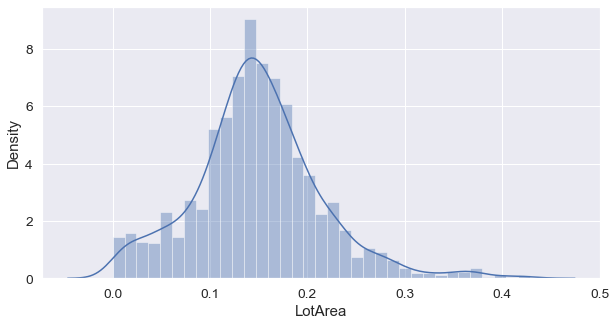

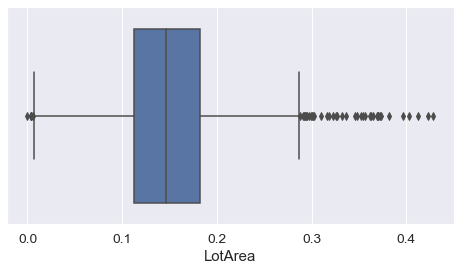

In [526]:
param = 'LotArea'
plt.figure(figsize=(10, 5))
sns.distplot(df_train[param])
plt.show()
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_train[param])
plt.show()

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

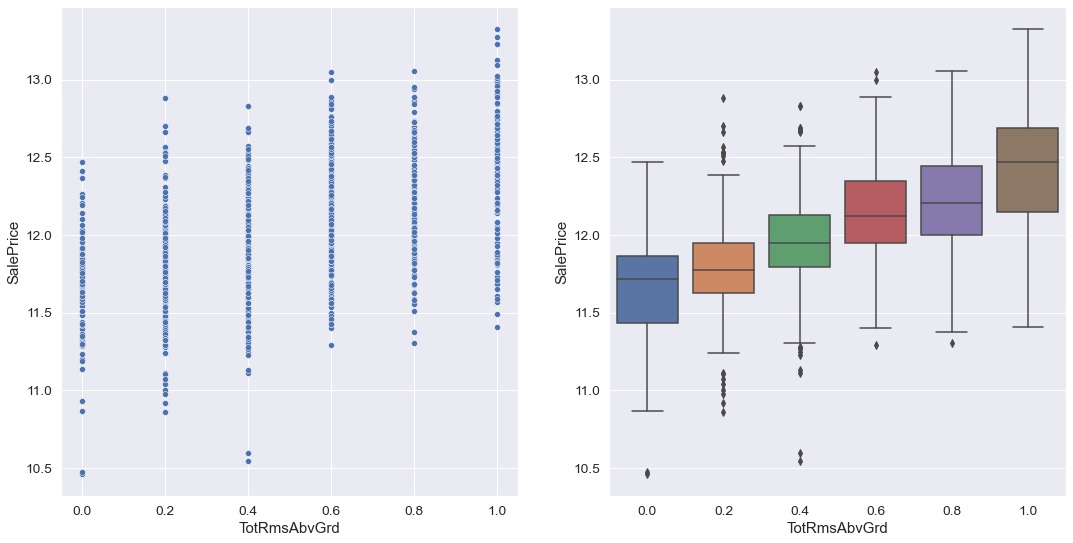

In [527]:
param = 'TotRmsAbvGrd'
target = 'SalePrice'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
sns.scatterplot(ax=ax[0], y=df_train[target], x=df_train[param])
sns.boxplot(ax=ax[1], y=target, x=param, data=df_train)

In [528]:
# features = [ # SalePrice выбросы обработаны
#     'TotalQualWithLog', # выбросы обработаны
#     'TotalSF', # выбросы обработаны 
# #     'Fireplaces',
#     'GrLivArea', # выбросы обработаны
#     'GarageCars',
#     'Neighborhood', 
#     'LotShape',
# #     'LandContour',
#     'SaleType', # выбросов нет
#     'TotalYear', # выбросы обработаны
#     'TotRmsAbvGrd', # пошаманил, но не уверен, что стало лучше =)
# #     'MSZoning',
# #     'GarageFinish',
# #     'GarageType',
#     'LotArea' # выбросы обработаны
# ]


# y = df_train['SalePrice']
# X = pd.get_dummies(df_train[features]) 
# test_X = pd.get_dummies(df_test[features])

# for i in features:
#     min_max(i, categorial_features)

# lin_model = LinearRegression()
# las_model = Lasso(alpha=60)
# cat_model = CatBoostRegressor(iterations=2000)
# xgb_model = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                          learning_rate=0.05, max_depth=3, 
#                          min_child_weight=1.7817, n_estimators=2200,
#                          reg_alpha=0.4640, reg_lambda=0.8571,
#                          subsample=0.5213, random_state=7, nthread=-1)
# lgb_model = LGBMRegressor()
    
# res_y1, res_y2, res_y3, res_y5, res_y6, res_y, k = 0, 0, 0, 0, 0, 0, 5
# pred_y1, pred_y2, pred_y5, pred_y6 = 0, 0, 0, 0

# for i in range(k):
#     train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.2)

#     lgb_model.fit(train_x, train_y)
#     pred_y1 += lgb_model.predict(test_X)
#     lin_model.fit(train_x, train_y)
#     pred_y2 += lin_model.predict(test_X)
#     cat_model.fit(train_x, train_y)
#     pred_y5 += cat_model.predict(test_X)
#     xgb_model.fit(train_x, train_y)
#     pred_y6 += xgb_model.predict(test_X)

# #     lgb_model.fit(train_x, train_y)
# #     pred_y1 += lgb_model.predict(val_x)
# # #     res_y1 += np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y1), squared=False)) 

# #     lin_model.fit(train_x, train_y)
# #     pred_y2 += lin_model.predict(val_x)
# # #     res_y2 += np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y2), squared=False)) 
    
# #     las_model.fit(train_x, train_y)
# #     pred_y3 += las_model.predict(val_x)
# # #     res_y3 += np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y3), squared=False))
    
# #     cat_model.fit(train_x, train_y)
# #     pred_y5 += cat_model.predict(val_x)
# # #     res_y5 += np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y5), squared=False))
    
# #     xgb_model.fit(train_x, train_y)
# #     pred_y6 += xgb_model.predict(val_x)
# # #     res_y6 += np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y6), squared=False))
    
# pred_y = (pred_y1 + pred_y2 + pred_y5 + pred_y6) / 4
# pred_y /= k
# res_y = np.sqrt(mean_squared_error(np.expm1(val_y), np.expm1(pred_y), squared=False))

# # pred_y1 = np.expm1(pred_y1 / k)
# # pred_y2 = np.expm1(pred_y2 / k)
# # pred_y5 = np.expm1(pred_y5 / k)
# # pred_y6 = np.expm1(pred_y6 / k)
# # pred_y = np.expm1(pred_y / k)

# # res_y1 /= k
# # res_y2 /= k 
# # res_y3 /= k
# # res_y5 /= k
# # res_y6 /= k
# # res_y = k

# # print(f'LGB: {res_y1}')
# # print(f'Linear: {res_y2}')
# # print(f'Lasso: {res_y3}')
# # print(f'Cat: {res_y5}')
# # print(f'XGB: {res_y6}')
# print(f'Ansamb: {res_y}')

In [529]:
# output = pd.DataFrame({'Id': df_test.Id.astype(int), 'SalePrice': pred_y})
# output.to_csv('submission.csv', index=False)

In [530]:
output = pd.DataFrame({'Id': df_test.Id.astype(int), 'SalePrice': np.expm1(pred_y)})
output.to_csv('submission.csv', index=False)

In [531]:
pearsonr(df_train['TotalSF'], df_train['SalePrice'])

(0.8171471663187562, 0.0)

<AxesSubplot:xlabel='TotalSF', ylabel='SalePrice'>

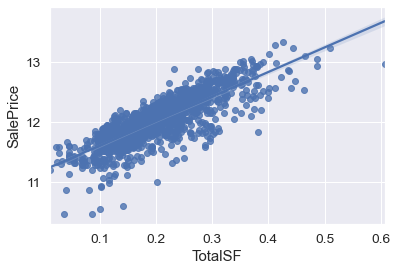

In [532]:
sns.regplot(x='TotalSF', y='SalePrice', data=df_train)